In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electric-car-sales-2010-2024/IEA-EV-dataEV salesHistoricalCars.csv


In [35]:
import numpy as np
import pandas as pd

In [36]:
df=pd.read_csv("/kaggle/input/electric-car-sales-2010-2024/IEA-EV-dataEV salesHistoricalCars.csv")

In [37]:
df.sample(10)

,region,category,parameter,mode,powertrain,year,unit,value
2349,Netherlands,Historical,EV sales share,Cars,EV,2017,percent,2.200
3769,World,Historical,EV stock,Cars,FCEV,2021,Vehicles,42000.000
3630,USA,Historical,EV sales,Cars,BEV,2022,Vehicles,800000.000
2827,Rest of the world,Historical,EV stock share,Cars,EV,2019,percent,0.013
1236,Finland,Historical,EV sales share,Cars,EV,2020,percent,18.000
3653,World,Historical,"Oil displacement, million lge",Cars,EV,2010,"Oil displacement, million lge",22.000
1998,Japan,Historical,EV sales share,Cars,EV,2014,percent,0.610
3065,Spain,Historical,EV stock,Cars,BEV,2016,Vehicles,6500.000
2837,Rest of the world,Historical,EV sales,Cars,FCEV,2020,Vehicles,4.000
397,Canada,Historical,EV sales share,Cars,EV,2013,percent,0.220


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      3798 non-null   object 
 1   category    3798 non-null   object 
 2   parameter   3798 non-null   object 
 3   mode        3798 non-null   object 
 4   powertrain  3798 non-null   object 
 5   year        3798 non-null   int64  
 6   unit        3798 non-null   object 
 7   value       3798 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 237.5+ KB


In [39]:
df.shape

(3798, 8)

In [40]:
df.columns

Index(['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit',
       'value'],
      dtype='object')

In [41]:
df.describe()

,year,value
count,3798.000000,3.798000e+03
mean,2017.369932,1.009542e+05
std,3.809226,8.184402e+05
min,2010.000000,1.500000e-05
25%,2014.000000,2.300000e+00
50%,2018.000000,1.900000e+02
75%,2021.000000,6.800000e+03
max,2023.000000,2.800000e+07


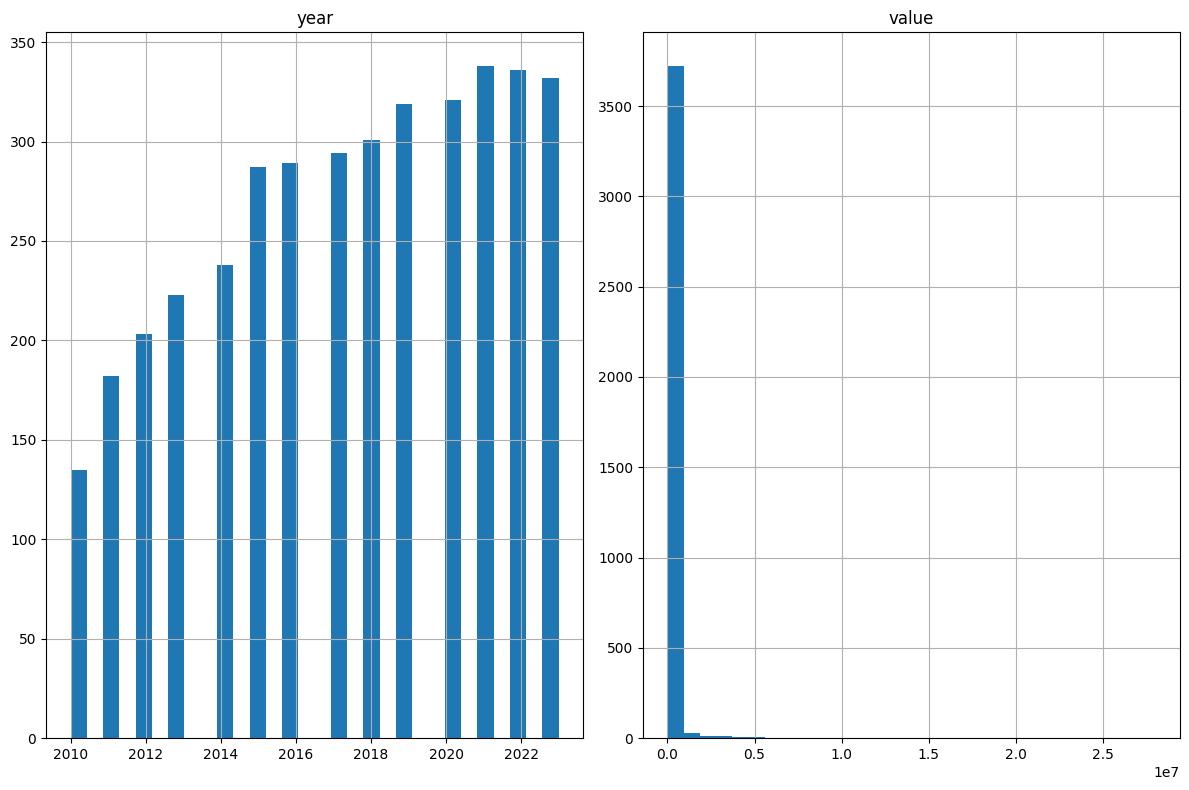

In [42]:
import matplotlib.pyplot as plt
# Distribution of numeric variables
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

Histogram of year and value (Figure 1)
Left panel (year): Shows that data is well distributed across years (mostly post-2010), suggesting it captures the recent growth of EV adoption.

Right panel (value): Highly right-skewed, indicating a few extremely large sales values (outliers), possibly from global aggregates like “World” or large countries like “China” or “USA”.

Takeaway: I’ll likely need to apply log transformation to normalize value for modeling.

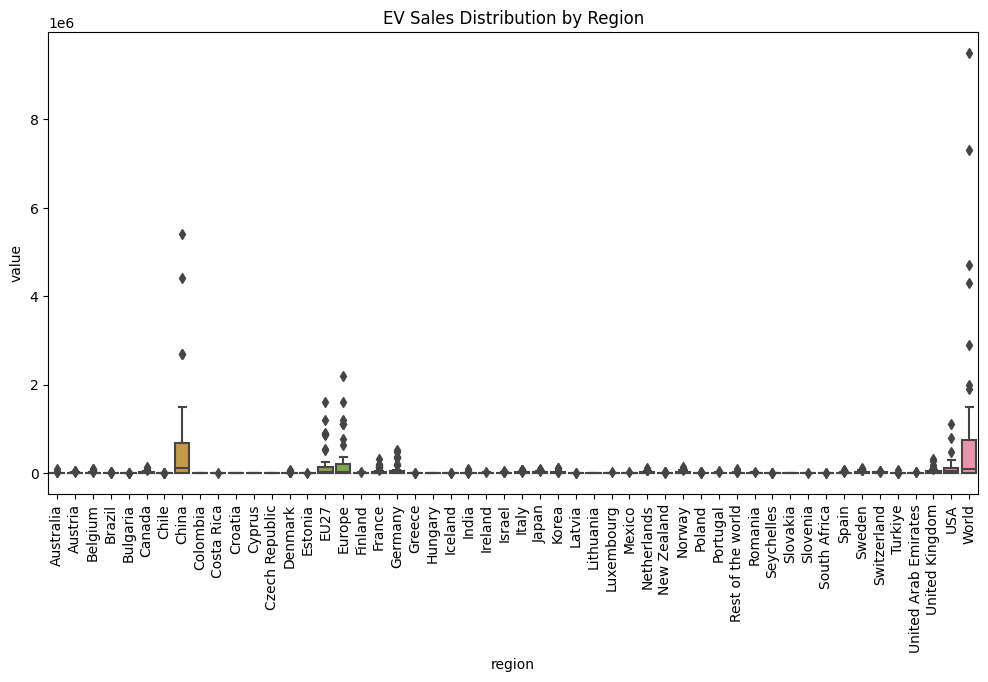

In [43]:
import seaborn as sns
# Boxplot of EV sales by region
if 'region' in df.columns and 'EV sales' in df['parameter'].unique():
    sales_data = df[df['parameter'] == 'EV sales']
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='region', y='value', data=sales_data)
    plt.xticks(rotation=90)
    plt.title('EV Sales Distribution by Region')
    plt.show()

Boxplot of EV Sales by Region (Figure 2)
Shows massive variability across regions, with a few countries like China and USA contributing outliers (high sales).

Many regions have low sales or none — some might not be useful for modeling, or might need special treatment.

Takeaway: I may consider filtering or aggregating regions, or clustering them by market maturity (e.g., high, medium, low sales zones).

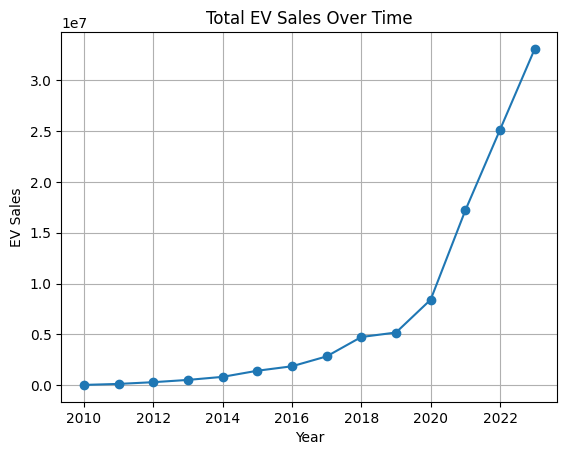

In [44]:
# Time trend of EV sales
if 'year' in df.columns and 'parameter' in df.columns:
    time_data = df[df['parameter'] == 'EV sales']
    time_data.groupby('year')['value'].sum().plot(marker='o')
    plt.title('Total EV Sales Over Time')
    plt.ylabel('EV Sales')
    plt.xlabel('Year')
    plt.grid(True)
    plt.show()

Total EV Sales Over Time (Figure 3)
Exhibits exponential growth, particularly after 2018.

Indicates strong temporal dependency — i.e., year is a powerful predictor.

Takeaway: Include year in modeling (possibly even polynomial features or exponential growth terms).

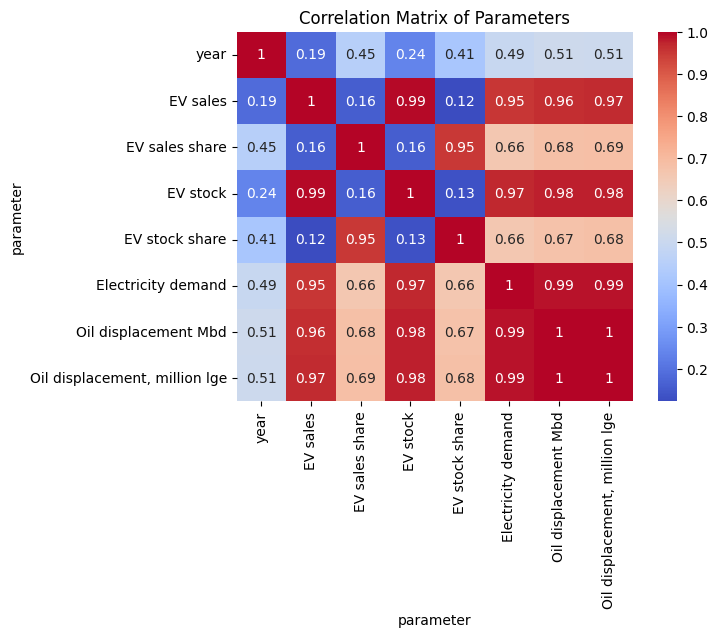

In [45]:
# Only select numeric parameter columns for correlation
df_wide = df.pivot_table(index=['region', 'year'], columns='parameter', values='value').reset_index()
numeric_df = df_wide.select_dtypes(include=['float64', 'int64'])

# Compute correlation on numeric columns only
corr = numeric_df.corr()

# Plot heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Parameters')
plt.show()


Correlation Matrix
Key insights:
EV stock and EV sales are nearly perfectly correlated (0.99).
Electricity demand, oil displacement, and EV stock/sales are strongly correlated.
EV stock share has weaker correlation to other variables.

Takeaway:
Avoid using both EV stock and EV sales together — high collinearity.
Electricity demand, oil displacement could serve as proxy indicators of market size or maturity.

In [46]:
# Parse datetime (if not already parsed)
df['year'] = pd.to_datetime(df['year'], format='%Y')

In [47]:
# Extract useful temporal features
df['year_numeric'] = df['year'].dt.year
df['is_leap_year'] = df['year'].dt.is_leap_year
df['decade'] = (df['year'].dt.year // 10) * 10

In [48]:
# Trend & Change over Time
df['value_diff'] = df['value'].diff()             
df['value_pct_change'] = df['value'].pct_change()

In [49]:
# Rolling statistics
df['value_rolling_mean_3'] = df['value'].rolling(window=3).mean()
df['value_rolling_std_3'] = df['value'].rolling(window=3).std()

In [50]:
# Lag features
df['value_lag_1'] = df['value'].shift(1)
df['value_lag_2'] = df['value'].shift(2)

In [51]:
# Encoding cyclical features (if seasonal patterns were observed)
df['year_sin'] = np.sin(2 * np.pi * df['year_numeric'] / df['year_numeric'].max())
df['year_cos'] = np.cos(2 * np.pi * df['year_numeric'] / df['year_numeric'].max())

In [52]:
df.drop(["category", "mode"], inplace=True, axis=1)
df.sample(10)

,region,parameter,powertrain,year,unit,value,year_numeric,is_leap_year,decade,value_diff,value_pct_change,value_rolling_mean_3,value_rolling_std_3,value_lag_1,value_lag_2,year_sin,year_cos
519,Chile,EV sales,PHEV,2019-01-01,Vehicles,140.00,2019,False,2010,-300.000,-0.681818,246.666667,167.729942,440.000,160.00,-1.242318e-02,0.999923
3313,Switzerland,EV sales,BEV,2023-01-01,Vehicles,53000.00,2023,False,2020,-43000.000,-0.447917,49676.666667,48071.234989,96000.000,30.00,-2.449294e-16,1.000000
1329,France,EV stock share,EV,2019-01-01,percent,0.66,2019,False,2010,0.060,0.100000,1.086667,0.797710,0.600,2.00,-1.242318e-02,0.999923
2719,Portugal,EV stock,BEV,2019-01-01,Vehicles,16000.00,2019,False,2010,15994.400,2856.142906,5335.406667,9235.809084,5.600,0.62,-1.242318e-02,0.999923
108,Austria,EV sales,BEV,2015-01-01,Vehicles,1700.00,2015,False,2010,-3300.000,-0.660000,2233.380000,2542.247170,5000.000,0.14,-2.484444e-02,0.999691
1863,Israel,EV stock,PHEV,2022-01-01,Vehicles,44000.00,2022,False,2020,28000.000,1.750000,34666.666667,16165.807538,16000.000,44000.00,-3.105870e-03,0.999995
1918,Italy,EV sales,PHEV,2017-01-01,Vehicles,2900.00,2017,False,2010,2889.000,262.636364,3570.333333,3937.529726,11.000,7800.00,-1.863417e-02,0.999826
1395,Germany,EV stock,BEV,2013-01-01,Vehicles,9200.00,2013,False,2010,9177.000,399.000000,3111.000000,5273.408102,23.000,110.00,-3.105376e-02,0.999518
1343,France,EV stock share,EV,2020-01-01,percent,1.10,2020,True,2020,-9.900,-0.900000,130.700000,215.956893,11.000,380.00,-9.317490e-03,0.999957
1146,Europe,"Oil displacement, million lge",EV,2020-01-01,"Oil displacement, million lge",1900.00,2020,True,2020,1899.968,59373.997180,1433.344000,1266.209885,0.032,2400.00,-9.317490e-03,0.999957


In [53]:
# Filter only rows where parameter == "EV sales"
ev_sales_df = df[df['parameter'] == 'EV sales'].copy()


In [54]:
# Drop 'parameter' column, since it’s constant ('EV sales')
ev_sales_df.drop(columns=['parameter'], inplace=True)

# Convert boolean columns to integers: True → 1, False → 0
# This will automatically catch columns like is_leap_year
bool_cols = ev_sales_df.select_dtypes(include=['bool']).columns
ev_sales_df[bool_cols] = ev_sales_df[bool_cols].astype(int)

# One-hot encode categorical columns (region, powertrain, unit)
ev_sales_df_encoded = pd.get_dummies(
    ev_sales_df,
    columns=['region', 'powertrain', 'unit'],
    drop_first=True  # avoid multicollinearity
)


In [55]:
ev_sales_df_encoded['log_EV_sales'] = np.log1p(ev_sales_df_encoded['value'])

In [56]:
ev_sales_df_encoded.sample(10)

,year,value,year_numeric,is_leap_year,decade,value_diff,value_pct_change,value_rolling_mean_3,value_rolling_std_3,value_lag_1,...,region_Sweden,region_Switzerland,region_Turkiye,region_USA,region_United Arab Emirates,region_United Kingdom,region_World,powertrain_FCEV,powertrain_PHEV,log_EV_sales
777,2019-01-01,760.0,2019,0,2010,7.595100e+02,1550.020378,410.163333,3.832743e+02,4.900000e-01,...,False,False,False,False,False,False,False,False,False,6.634633
2908,2021-01-01,61.0,2021,0,2020,5.680000e+01,13.523810,22.833333,3.305652e+01,4.200000e+00,...,False,False,False,False,False,False,False,False,False,4.127134
2034,2019-01-01,670.0,2019,0,2010,6.691400e+02,778.069754,223.756667,3.864581e+02,8.600000e-01,...,False,False,False,False,False,False,False,True,False,6.508769
9,2012-01-01,170.0,2012,1,2010,1.699976e+02,70832.329969,56.677467,9.814019e+01,2.400000e-03,...,False,False,False,False,False,False,False,False,False,5.141664
295,2015-01-01,61.0,2015,0,2010,3.300000e+01,1.178571,69.666667,4.660830e+01,2.800000e+01,...,False,False,False,False,False,False,False,False,False,4.127134
1577,2012-01-01,17.0,2012,1,2010,8.000000e+00,0.888889,15.333333,5.687099e+00,9.000000e+00,...,False,False,False,False,False,False,False,False,False,2.890372
3049,2013-01-01,72.0,2013,0,2010,-1.628000e+03,-0.957647,860.666667,8.151818e+02,1.700000e+03,...,False,False,False,False,False,False,False,False,True,4.290459
1011,2021-01-01,890000.0,2021,0,2020,-1.110000e+06,-0.555000,963620.000000,1.001601e+06,2.000000e+06,...,False,False,False,False,False,False,False,False,False,13.698978
2611,2016-01-01,110.0,2016,1,2010,4.000000e+01,0.571429,893.333333,1.391558e+03,7.000000e+01,...,False,False,False,False,False,False,False,False,False,4.709530
171,2023-01-01,48000.0,2023,0,2020,-1.120000e+05,-0.700000,69334.800000,8.210377e+04,1.600000e+05,...,False,False,False,False,False,False,False,False,False,10.778977


In [57]:
# Convert all boolean columns to integers
bool_cols = ev_sales_df_encoded.select_dtypes(include='bool').columns
ev_sales_df_encoded[bool_cols] = ev_sales_df_encoded[bool_cols].astype(int)


In [58]:
ev_sales_df_encoded.sample(10)

,year,value,year_numeric,is_leap_year,decade,value_diff,value_pct_change,value_rolling_mean_3,value_rolling_std_3,value_lag_1,...,region_Sweden,region_Switzerland,region_Turkiye,region_USA,region_United Arab Emirates,region_United Kingdom,region_World,powertrain_FCEV,powertrain_PHEV,log_EV_sales
1290,2014-01-01,1.0,2014,0,2010,-10999.00,-0.999909,6633.666667,5839.237993,11000.00,...,0,0,0,0,0,0,0,1,0,0.693147
948,2014-01-01,33000.0,2014,0,2010,12000.00,0.571429,32666.666667,11503.622618,21000.00,...,0,0,0,0,0,0,0,0,0,10.404293
744,2021-01-01,400.0,2021,0,2020,396.20,104.263159,135.233333,229.296643,3.80,...,0,0,0,0,0,0,0,0,1,5.993961
1519,2020-01-01,1500.0,2020,1,2020,-700.00,-0.318182,1233.361000,1123.935487,2200.00,...,0,0,0,0,0,0,0,0,1,7.313887
1444,2019-01-01,45000.0,2019,0,2010,-18000.00,-0.285714,82666.666667,50461.206222,63000.00,...,0,0,0,0,0,0,0,0,1,10.714440
1963,2023-01-01,2.0,2023,0,2020,-65998.00,-0.999970,22003.733333,38101.884775,66000.00,...,0,0,0,0,0,0,0,1,0,1.098612
1397,2013-01-01,1600.0,2013,0,2010,-3600.00,-0.692308,5333.333333,3801.753982,5200.00,...,0,0,0,0,0,0,0,0,1,7.378384
512,2018-01-01,68.0,2018,0,2010,67.93,970.428567,22.693667,39.236446,0.07,...,0,0,0,0,0,0,0,0,1,4.234107
761,2022-01-01,230.0,2022,0,2020,224.60,41.592592,79.033333,130.754085,5.40,...,0,0,0,0,0,0,0,0,1,5.442418
1247,2021-01-01,10000.0,2021,0,2020,9999.00,9999.000000,11000.333333,11532.085689,1.00,...,0,0,0,0,0,0,0,0,0,9.210440


In [59]:
ev_sales_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1342 entries, 0 to 3794
Data columns (total 67 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   year                         1342 non-null   datetime64[ns]
 1   value                        1342 non-null   float64       
 2   year_numeric                 1342 non-null   int32         
 3   is_leap_year                 1342 non-null   int64         
 4   decade                       1342 non-null   int32         
 5   value_diff                   1341 non-null   float64       
 6   value_pct_change             1341 non-null   float64       
 7   value_rolling_mean_3         1341 non-null   float64       
 8   value_rolling_std_3          1341 non-null   float64       
 9   value_lag_1                  1341 non-null   float64       
 10  value_lag_2                  1341 non-null   float64       
 11  year_sin                     1342 non-null   flo

In [60]:
# If 'year' is datetime, extract year as integer
ev_sales_df_encoded['year'] = ev_sales_df_encoded['year'].dt.year


In [61]:
X = ev_sales_df_encoded.drop(columns=['value', 'log_EV_sales'])

# Define target
y = ev_sales_df_encoded['log_EV_sales']

In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [63]:
from sklearn.preprocessing import StandardScaler

# Standardize features for models sensitive to scale (like SVR and KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [65]:
from sklearn.impute import SimpleImputer

# Replace NaNs with column means
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.transform(X_test_scaled)


# Train model
model = LinearRegression()
model.fit(X_train_imputed, y_train)

# Predict
y_pred = model.predict(X_test_imputed)


In [66]:
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Mean Squared Error: 1.7171548531444092
R² Score: 0.8357681963571527
